In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

# Load your dataset
df = pd.read_csv("cleaned_tcga_stad_data_with_encoded_clinical.csv")

# Drop columns that are not input features
X = df.drop(columns=["sample", "OS", "OS.time"])  # features
y = df["OS"]  # target label

# Handle invalid values
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# === Print Feature Input Summary ===
print("🔹 Input Feature Data (X):")
print(X.head())  # show first 5 rows
print("\nShape of X (rows, columns):", X.shape)

# === Print Target Label Summary ===
print("\n🔹 Target Labels (y):")
print(y.head())
print("\nShape of y:", y.shape)

# === Print Class Balance ===
print("\n🔹 Class Distribution in Target:")
print(y.value_counts())

# === Optional: Print Column Info ===
print("\n🔹 Feature Names and Types:")
print(X.dtypes)


🔹 Input Feature Data (X):
   days_to_birth  days_to_collection  days_to_last_followup  PFI.time  \
0       0.000000            0.000000           2.308577e+00  2.601525   
1       0.000000            1.982404          -2.158329e-16  0.000000   
2       1.403139            0.000000           4.993193e-01  0.416198   
3       0.322585            0.000000          -3.663905e-01  0.000000   
4       1.319735           -1.133889           8.734774e-02 -0.081405   

   DSS.time  DFI.time  initial_weight  \
0  2.186637  2.287743        0.000000   
1 -0.359423  0.000000       -0.468329   
2  0.415546  0.484246        0.000000   
3 -0.431902 -0.378707        0.000000   
4  0.012265  0.073586       -0.353610   

   days_to_new_tumor_event_after_initial_treatment  \
0                                         0.000000   
1                                        -0.003605   
2                                         0.000000   
3                                         0.000000   
4                 

VotingClassifier (RandomForest + LogisticRegression + CatBoost):
Accuracy: 0.9877
F1 Score: 0.9841
Recall: 1.0
ROC AUC: 0.9955
AUPR: 0.9922


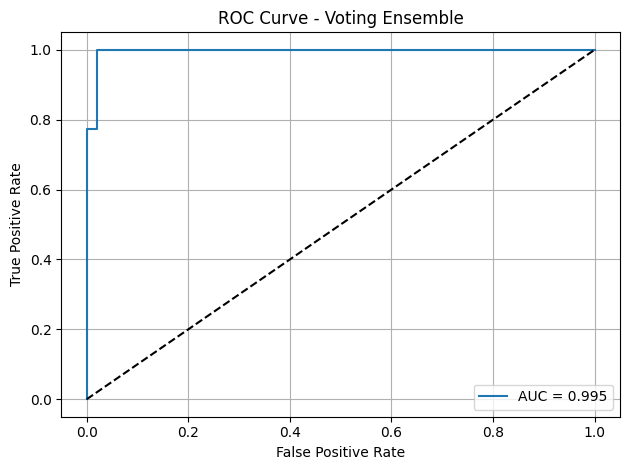

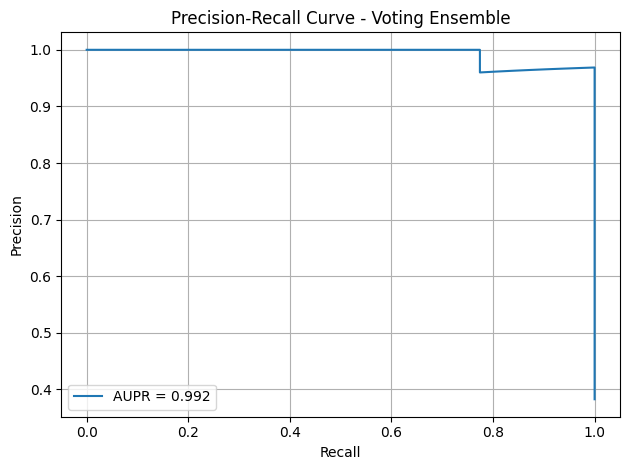

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import (
    accuracy_score, f1_score, recall_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

# === Load and clean dataset ===
df = pd.read_csv("cleaned_tcga_stad_data_with_encoded_clinical.csv")

X = df.drop(columns=["sample", "OS", "OS.time"])
y = df["OS"]

X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Define Base Models ===
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

clf_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='lbfgs', max_iter=5000, random_state=42)
)

clf_cat = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    verbose=0,
    random_state=42,
    eval_metric='AUC',
    use_best_model=False
)

# === Voting Classifier (Soft Voting) ===
voting_model = VotingClassifier(
    estimators=[('rf', clf_rf), ('lr', clf_lr), ('cat', clf_cat)],
    voting='soft'
)

# === Train Ensemble ===
voting_model.fit(X_train, y_train)

# === Predictions ===
y_pred = voting_model.predict(X_test)
y_proba = voting_model.predict_proba(X_test)[:, 1]

# === Evaluation ===
print("VotingClassifier (RandomForest + LogisticRegression + CatBoost):")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("AUPR:", round(average_precision_score(y_test, y_proba), 4))

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Voting Ensemble")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Precision-Recall Curve ===
precision, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall_vals, precision, label=f"AUPR = {average_precision_score(y_test, y_proba):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Voting Ensemble")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

VotingClassifier (Soft) - Logistic + RF + GaussianNB:
Accuracy: 0.9753
F1 Score: 0.9677
Recall: 0.9677
ROC AUC: 0.9942
AUPR: 0.9907


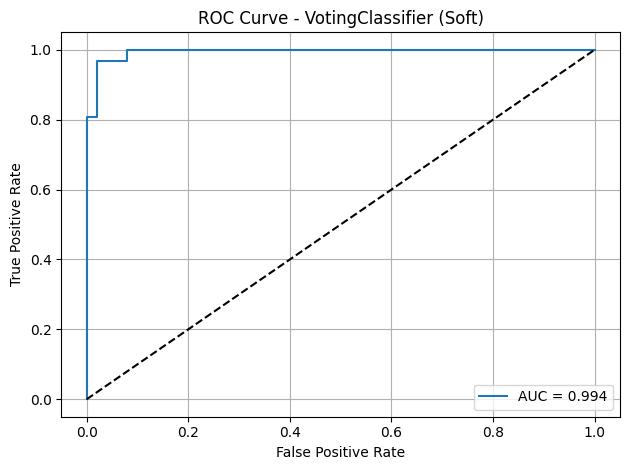

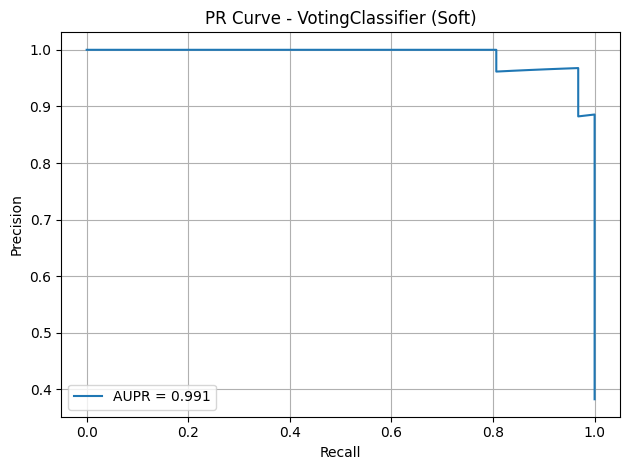

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

# === Load dataset ===
df = pd.read_csv("cleaned_tcga_stad_data_with_encoded_clinical.csv")
X = df.drop(columns=["sample", "OS", "OS.time"])
y = df["OS"]
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Define individual models ===
clf_log = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=3000, solver='saga', random_state=42)
)
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_nb = make_pipeline(
    StandardScaler(),
    GaussianNB()
)

# === Voting Ensemble (Soft Voting) ===
voting_clf = VotingClassifier(
    estimators=[
        ('logistic', clf_log),
        ('rf', clf_rf),
        ('nb', clf_nb)
    ],
    voting='soft'  # uses predict_proba for probability averaging
)

# === Train ensemble ===
voting_clf.fit(X_train, y_train)

# === Predict and evaluate ===
y_proba = voting_clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("VotingClassifier (Soft) - Logistic + RF + GaussianNB:")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("AUPR:", round(average_precision_score(y_test, y_proba), 4))

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - VotingClassifier (Soft)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Precision-Recall Curve ===
precision, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall_vals, precision, label=f"AUPR = {average_precision_score(y_test, y_proba):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve - VotingClassifier (Soft)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


VotingClassifier (Soft) - MLP + LGBM + Calibrated:
Accuracy: 0.9753
F1 Score: 0.9677
Recall: 0.9677
ROC AUC: 0.9852
AUPR: 0.9603


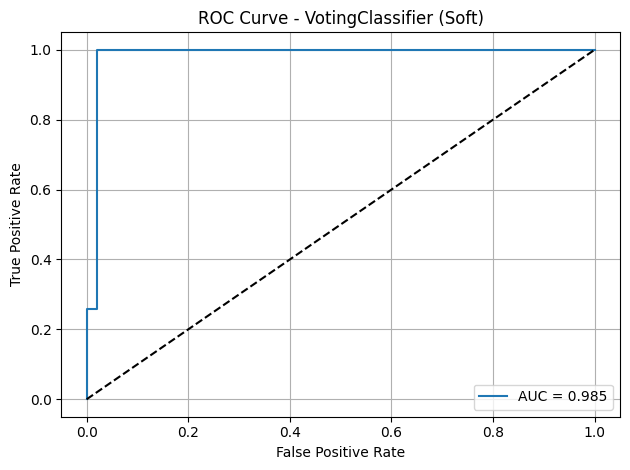

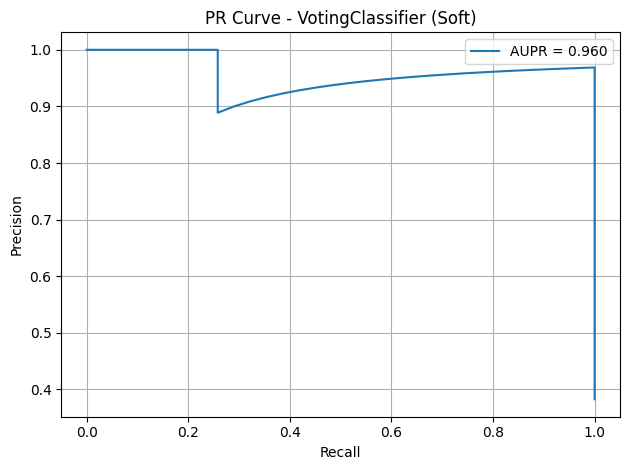

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

# === Load dataset ===
df = pd.read_csv("cleaned_tcga_stad_data_with_encoded_clinical.csv")
X = df.drop(columns=["sample", "OS", "OS.time"])
y = df["OS"]
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Define models ===

# 1. MLPClassifier with scaling
clf_mlp = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
)

# 2. LGBMClassifier (no scaling required)
clf_lgbm = LGBMClassifier(
    random_state=42,
    min_data_in_leaf=1,
    min_gain_to_split=0.0,
    force_col_wise=True,
    verbose=-1
)

# 3. CalibratedClassifierCV with LogisticRegression as base
clf_calibrated = make_pipeline(
    StandardScaler(),
    CalibratedClassifierCV(LogisticRegression(max_iter=1000), method='sigmoid', cv=5)
)

# === Voting Ensemble (Soft Voting) ===
voting_clf = VotingClassifier(
    estimators=[
        ('mlp', clf_mlp),
        ('lgbm', clf_lgbm),
        ('calibrated', clf_calibrated)
    ],
    voting='soft'
)

# === Train ensemble ===
voting_clf.fit(X_train, y_train)

# === Predict and evaluate ===
y_proba = voting_clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("VotingClassifier (Soft) - MLP + LGBM + Calibrated:")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("AUPR:", round(average_precision_score(y_test, y_proba), 4))

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - VotingClassifier (Soft)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Precision-Recall Curve ===
precision, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall_vals, precision, label=f"AUPR = {average_precision_score(y_test, y_proba):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve - VotingClassifier (Soft)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


StackingClassifier - KNN + Ridge + BernoulliNB → LogisticRegression:
Accuracy: 0.9506
F1 Score: 0.9333
Recall: 0.9032
ROC AUC: 0.9406
AUPR: 0.9578


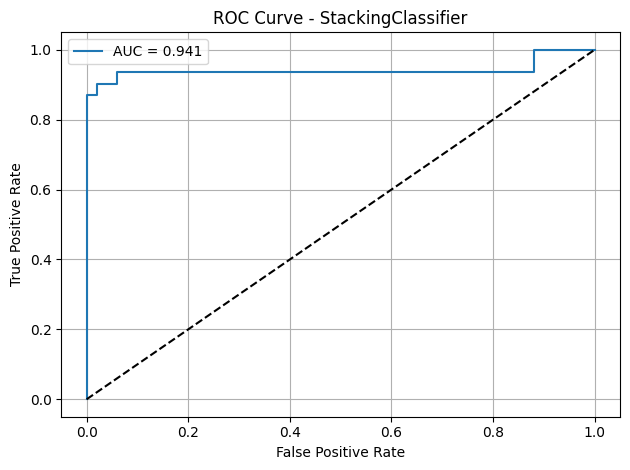

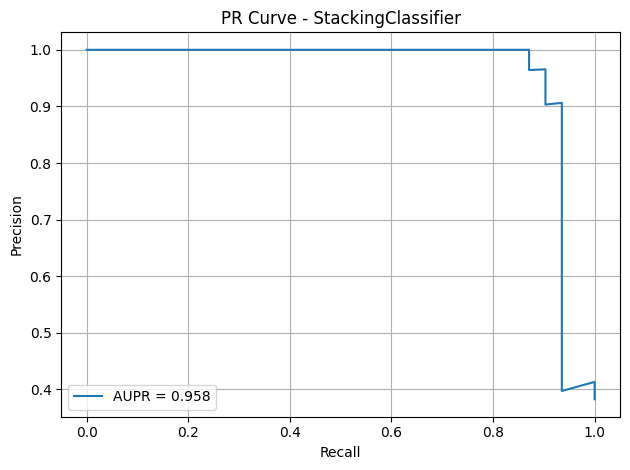

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
#linear
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

# === Load dataset ===
df = pd.read_csv("cleaned_tcga_stad_data_with_encoded_clinical.csv")
X = df.drop(columns=["sample", "OS", "OS.time"])
y = df["OS"]
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Define base learners with preprocessing ===

# 1. KNN needs scaling
knn = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=5)
)

# 2. Ridge needs scaling
ridge = make_pipeline(
    StandardScaler(),
    RidgeClassifier()
)

# 3. BernoulliNB requires binarized features
nb = make_pipeline(
    Binarizer(),
    BernoulliNB()
)

# === Define meta-learner ===
meta_model = LogisticRegression(max_iter=3000, solver='saga')

# === Create stacking classifier ===
stacking_clf = StackingClassifier(
    estimators=[
        ('knn', knn),
        ('ridge', ridge),
        ('nb', nb)
    ],
    final_estimator=meta_model,
    cv=5,
    passthrough=True  # include original features in meta-model
)

# === Train the ensemble ===
stacking_clf.fit(X_train, y_train)

# === Predict and evaluate ===
y_proba = stacking_clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("StackingClassifier - KNN + Ridge + BernoulliNB → LogisticRegression:")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("AUPR:", round(average_precision_score(y_test, y_proba), 4))

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - StackingClassifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === PR Curve ===
precision, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall_vals, precision, label=f"AUPR = {average_precision_score(y_test, y_proba):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve - StackingClassifier")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


StackingClassifier (XGB + CatBoost + GBDT → DecisionTree):
Accuracy: 0.963
F1 Score: 0.9508
Recall: 0.9355
ROC AUC: 0.9577
AUPR: 0.929


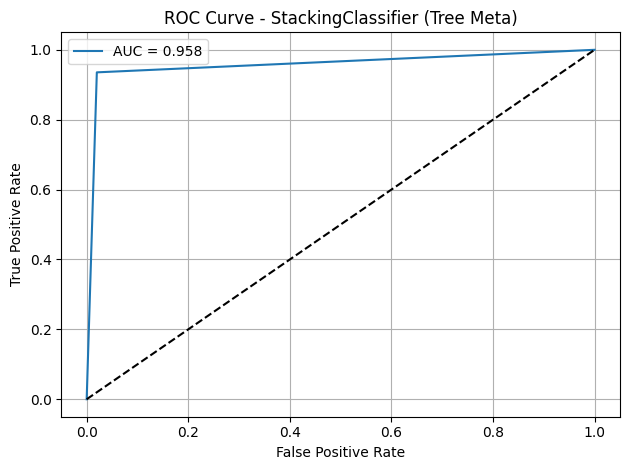

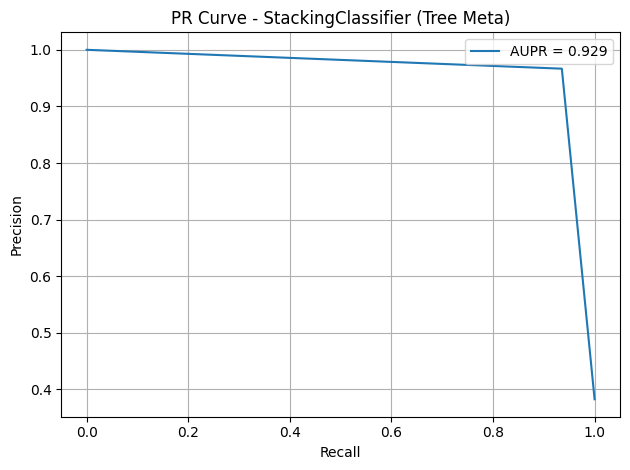

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

# === Load dataset ===
df = pd.read_csv("cleaned_tcga_stad_data_with_encoded_clinical.csv")
X = df.drop(columns=["sample", "OS", "OS.time"])
y = df["OS"]
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Base models ===
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

# === Meta-model ===
meta_model = DecisionTreeClassifier(max_depth=3, random_state=42)

# === StackingClassifier ===
stack_clf = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('cat', cat),
        ('gb', gb)
    ],
    final_estimator=meta_model,
    cv=5,
    passthrough=True
)

# === Train the ensemble ===
stack_clf.fit(X_train, y_train)

# === Predict and evaluate ===
y_proba = stack_clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("StackingClassifier (XGB + CatBoost + GBDT → DecisionTree):")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("AUPR:", round(average_precision_score(y_test, y_proba), 4))

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - StackingClassifier (Tree Meta)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Precision-Recall Curve ===
precision, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall_vals, precision, label=f"AUPR = {average_precision_score(y_test, y_proba):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve - StackingClassifier (Tree Meta)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


StackingClassifier (XGB + DecisionTree + BernoulliNB):
Accuracy: 0.9877
F1 Score: 0.9841
Recall: 1.0
ROC AUC: 0.9935
AUPR: 0.9881


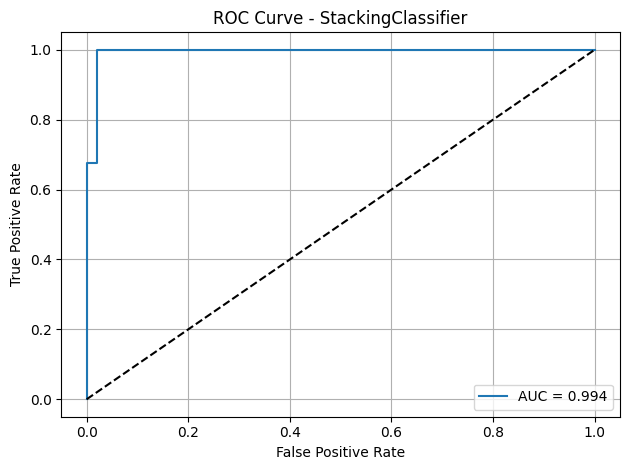

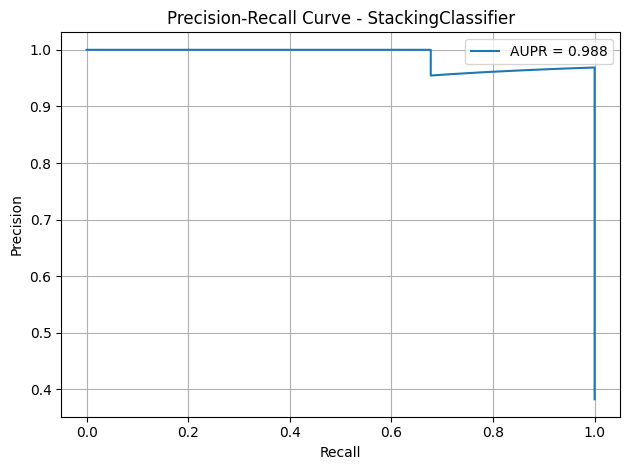

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Binarizer
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
from xgboost import XGBClassifier

# === Load dataset ===
df = pd.read_csv("cleaned_tcga_stad_data_with_encoded_clinical.csv")

# Features and target
X = df.drop(columns=["sample", "OS", "OS.time"])
y = df["OS"]

# Clean data
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Define base models ===
clf_xgb = XGBClassifier(eval_metric='logloss', random_state=42)  # ✅ cleaned
clf_dt = DecisionTreeClassifier(random_state=42)
clf_nb = make_pipeline(Binarizer(), BernoulliNB())

# Meta-learner
meta_model = LogisticRegression(max_iter=1000, solver='lbfgs')

# === Stacking Classifier ===
model = StackingClassifier(
    estimators=[
        ('xgb', clf_xgb),
        ('dt', clf_dt),
        ('bnb', clf_nb)
    ],
    final_estimator=meta_model,
    passthrough=False,
    cv=5
)

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluate
print("StackingClassifier (XGB + DecisionTree + BernoulliNB):")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("AUPR:", round(average_precision_score(y_test, y_proba), 4))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - StackingClassifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall_vals, precision, label=f"AUPR = {average_precision_score(y_test, y_proba):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - StackingClassifier")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Blending Ensemble (Bagging + AdaBoost + Lasso):
Accuracy: 0.9877
F1 Score: 0.9841
Recall: 1.0
ROC AUC: 1.0
AUPR: 1.0


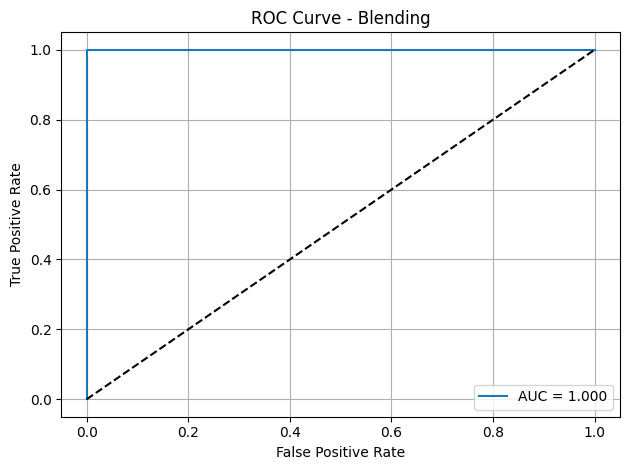

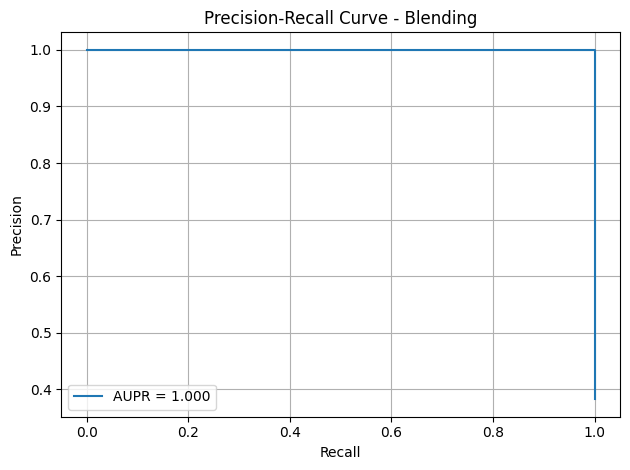

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

# === Load dataset ===
df = pd.read_csv("cleaned_tcga_stad_data_with_encoded_clinical.csv")

X = df.drop(columns=["sample", "OS", "OS.time"])
y = df["OS"]

X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# === Create train / validation / test splits ===
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, stratify=y_temp, test_size=0.25, random_state=42
)
# Now: train = 60%, val = 20%, test = 20%

# === Define base models ===
model_bag = BaggingClassifier(n_estimators=100, random_state=42)
model_ada = AdaBoostClassifier(n_estimators=100, random_state=42)
model_lasso = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l1', solver='saga', max_iter=5000, random_state=42)
)

# === Fit base models on training set ===
model_bag.fit(X_train, y_train)
model_ada.fit(X_train, y_train)
model_lasso.fit(X_train, y_train)

# === Get validation predictions (for meta-model training) ===
val_preds = np.column_stack([
    model_bag.predict_proba(X_val)[:, 1],
    model_ada.predict_proba(X_val)[:, 1],
    model_lasso.predict_proba(X_val)[:, 1]
])

# === Train meta-model (blender) on validation set predictions ===
meta_model = LogisticRegression(max_iter=1000, solver='lbfgs')
meta_model.fit(val_preds, y_val)

# === Make final predictions on the test set ===
test_preds = np.column_stack([
    model_bag.predict_proba(X_test)[:, 1],
    model_ada.predict_proba(X_test)[:, 1],
    model_lasso.predict_proba(X_test)[:, 1]
])
y_pred = meta_model.predict(test_preds)
y_proba = meta_model.predict_proba(test_preds)[:, 1]

# === Evaluation ===
print("Blending Ensemble (Bagging + AdaBoost + Lasso):")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("AUPR:", round(average_precision_score(y_test, y_proba), 4))

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Blending")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Precision-Recall Curve ===
precision, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall_vals, precision, label=f"AUPR = {average_precision_score(y_test, y_proba):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Blending")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Softmax-Weighted Ensemble (CatBoost + LogisticRegression + MLPClassifier):
Model Weights: {'LogReg': np.float64(0.488), 'CatBoost': np.float64(0.212), 'MLP': np.float64(0.3)}
Accuracy: 0.9506
F1 Score: 0.9333
Recall: 0.9032
ROC AUC: 0.9884
AUPR: 0.9774


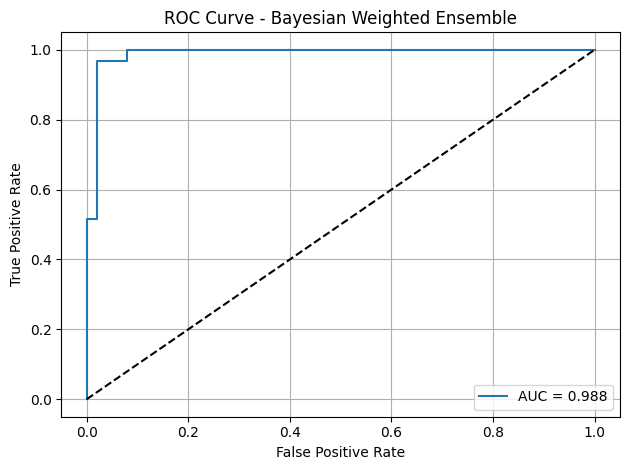

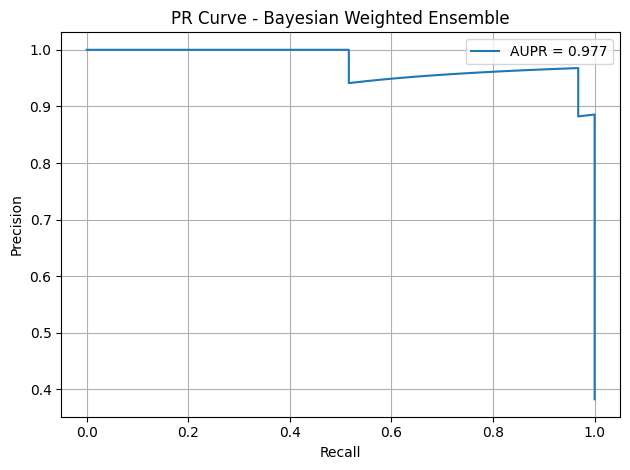

In [ ]:
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

# === Load dataset ===
df = pd.read_csv("cleaned_tcga_stad_data_with_encoded_clinical.csv")
X = df.drop(columns=["sample", "OS", "OS.time"])
y = df["OS"]
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# === Split data ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Define and train models ===

# Logistic Regression with scaling
log_reg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, solver='lbfgs')
)
log_reg.fit(X_train, y_train)

# CatBoost (silent training)
cat = CatBoostClassifier(verbose=0, random_state=42)
cat.fit(X_train, y_train)

# MLPClassifier with scaling
mlp = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
)
mlp.fit(X_train, y_train)

# === Predict probabilities ===
proba_log = log_reg.predict_proba(X_test)[:, 1]
proba_cat = cat.predict_proba(X_test)[:, 1]
proba_mlp = mlp.predict_proba(X_test)[:, 1]

# === Simulated Bayesian Averaging using softmax over logit scores ===
def sigmoid(x): return 1 / (1 + np.exp(-x))
def logit(p): return np.log(p / (1 - p))

# Convert probas to logits (avoid division by zero)
eps = 1e-6
logits = np.array([
    logit(np.clip(proba_log, eps, 1 - eps)),
    logit(np.clip(proba_cat, eps, 1 - eps)),
    logit(np.clip(proba_mlp, eps, 1 - eps))
])

# Weight by softmax of model confidences (simulated BMA)
weights = np.exp(np.abs(logits)).mean(axis=1)
weights = weights / weights.sum()

# Combine using weighted logits, then convert back to probability
avg_logit = np.average(logits, axis=0, weights=weights)
y_proba = sigmoid(avg_logit)
y_pred = (y_proba >= 0.5).astype(int)

# === Evaluation ===
print("Softmax-Weighted Ensemble (CatBoost + LogisticRegression + MLPClassifier):")
print("Model Weights:", dict(zip(['LogReg', 'CatBoost', 'MLP'], weights.round(3))))
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("AUPR:", round(average_precision_score(y_test, y_proba), 4))

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Bayesian Weighted Ensemble")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === PR Curve ===
precision, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall_vals, precision, label=f"AUPR = {average_precision_score(y_test, y_proba):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve - Bayesian Weighted Ensemble")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Selected Ensemble Members (with repetitions): ['LGBM', 'KNN']
Greedy Ensemble (KNN + Calibrated + LGBM):
Accuracy: 0.9383
F1 Score: 0.9206
Recall: 0.9355
ROC AUC: 0.9613
AUPR: 0.904


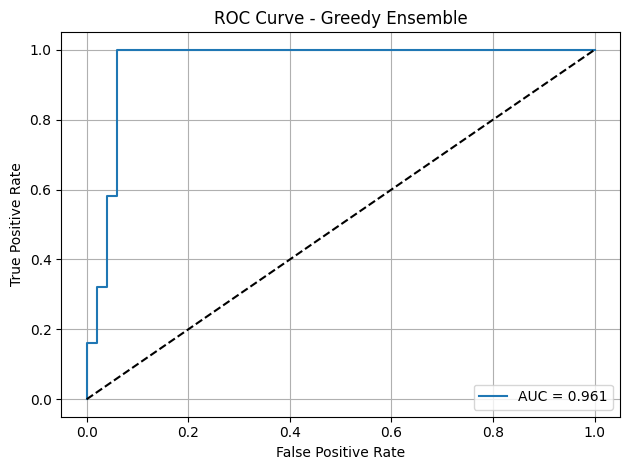

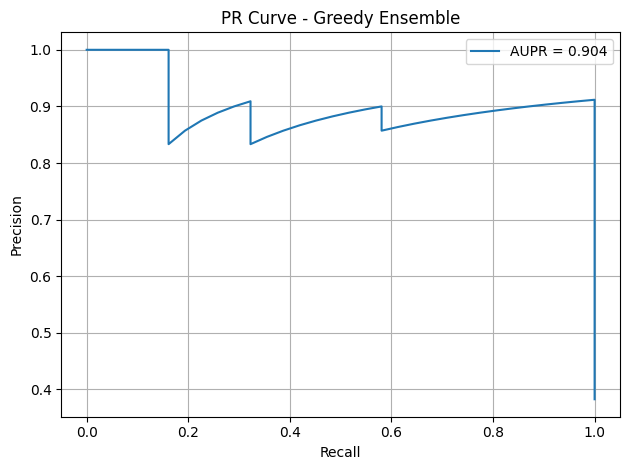

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    accuracy_score, f1_score, recall_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

# === Load dataset ===
df = pd.read_csv("cleaned_tcga_stad_data_with_encoded_clinical.csv")
X = df.drop(columns=["sample", "OS", "OS.time"])
y = df["OS"]
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# === Split: train (60%), val (20%), test (20%) ===
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

# === Define and train models ===

# 1. KNN with scaling
model_knn = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=7)
)
model_knn.fit(X_train, y_train)

# 2. Calibrated Logistic Regression
model_cal = make_pipeline(
    StandardScaler(),
    CalibratedClassifierCV(LogisticRegression(max_iter=1000), method='sigmoid', cv=5)
)
model_cal.fit(X_train, y_train)

# 3. LGBMClassifier with warnings suppressed
model_lgbm = LGBMClassifier(
    random_state=42,
    min_data_in_leaf=1,
    min_gain_to_split=0.0,
    force_col_wise=True,
    verbose=-1
)
model_lgbm.fit(X_train, y_train)

# === Get probabilities on val and test sets ===
val_probas = {
    "KNN": model_knn.predict_proba(X_val)[:, 1],
    "Calibrated": model_cal.predict_proba(X_val)[:, 1],
    "LGBM": model_lgbm.predict_proba(X_val)[:, 1]
}
test_probas = {
    "KNN": model_knn.predict_proba(X_test)[:, 1],
    "Calibrated": model_cal.predict_proba(X_test)[:, 1],
    "LGBM": model_lgbm.predict_proba(X_test)[:, 1]
}

# === Greedy Ensemble Selection ===
ensemble = []
best_auc = 0
n_rounds = 10  # max ensemble size

for i in range(n_rounds):
    best_model = None
    best_score = best_auc

    for name, val_pred in val_probas.items():
        temp_ensemble = [val_probas[m] for m in ensemble] + [val_pred]
        avg_val_pred = np.mean(temp_ensemble, axis=0)
        score = roc_auc_score(y_val, avg_val_pred)

        if score > best_score:
            best_model = name
            best_score = score

    if best_model:
        ensemble.append(best_model)
        best_auc = best_score
    else:
        break  # stop if no improvement

# === Final prediction on test set ===
print("Selected Ensemble Members (with repetitions):", ensemble)
final_test_preds = np.mean([test_probas[m] for m in ensemble], axis=0)
y_pred = (final_test_preds >= 0.5).astype(int)

# === Evaluation ===
print("Greedy Ensemble (KNN + Calibrated + LGBM):")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, final_test_preds), 4))
print("AUPR:", round(average_precision_score(y_test, final_test_preds), 4))

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, final_test_preds)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, final_test_preds):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Greedy Ensemble")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Precision-Recall Curve ===
precision, recall_vals, _ = precision_recall_curve(y_test, final_test_preds)
plt.figure()
plt.plot(recall_vals, precision, label=f"AUPR = {average_precision_score(y_test, final_test_preds):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve - Greedy Ensemble")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Soft Voting (GB + Logistic + BernoulliNB):
Accuracy: 0.963
F1 Score: 0.9538
Recall: 1.0
ROC AUC: 0.9832
AUPR: 0.9685


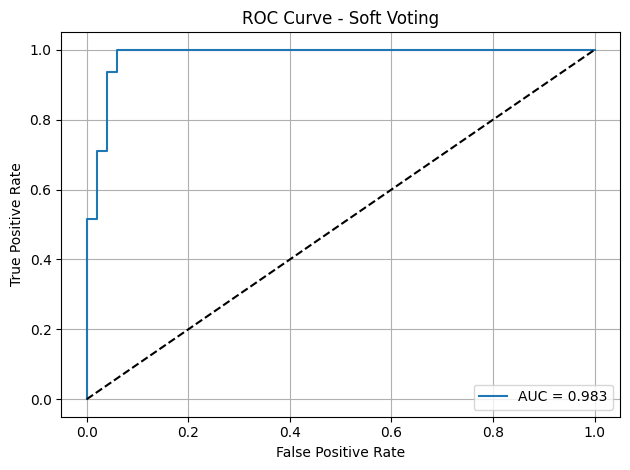

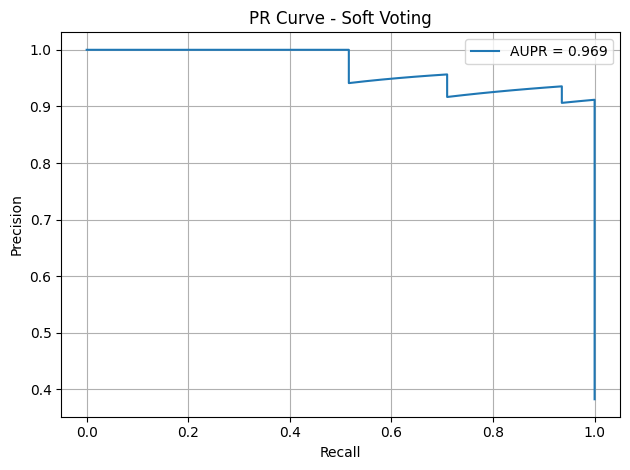

In [ ]:
#
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Binarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# === Load dataset ===
df = pd.read_csv("cleaned_tcga_stad_data_with_encoded_clinical.csv")
X = df.drop(columns=["sample", "OS", "OS.time"])
y = df["OS"]
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Define models ===
clf_gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

clf_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=3000, solver='saga', random_state=42)
)

clf_nb = make_pipeline(
    Binarizer(),  # BernoulliNB requires binary features
    BernoulliNB()
)

# === Voting Classifier (Soft Voting) ===
voting_clf = VotingClassifier(
    estimators=[
        ('gb', clf_gb),
        ('lr', clf_lr),
        ('nb', clf_nb)
    ],
    voting='soft'
)

# === Train ensemble ===
voting_clf.fit(X_train, y_train)

# === Predict & Evaluate ===
y_proba = voting_clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("Soft Voting (GB + Logistic + BernoulliNB):")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("AUPR:", round(average_precision_score(y_test, y_proba), 4))

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Soft Voting")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Precision-Recall Curve ===
precision, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall_vals, precision, label=f"AUPR = {average_precision_score(y_test, y_proba):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve - Soft Voting")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Hybrid Meta-Ensemble (LGBM + MLP + QDA):
Accuracy: 0.9383
F1 Score: 0.9153
Recall: 0.871
ROC AUC: 0.9406
AUPR: 0.9578


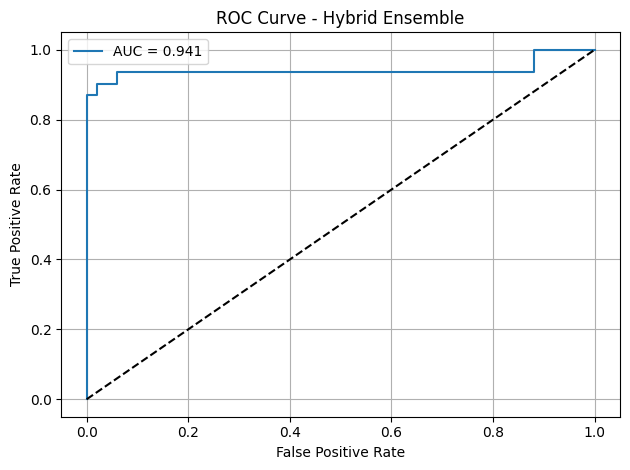

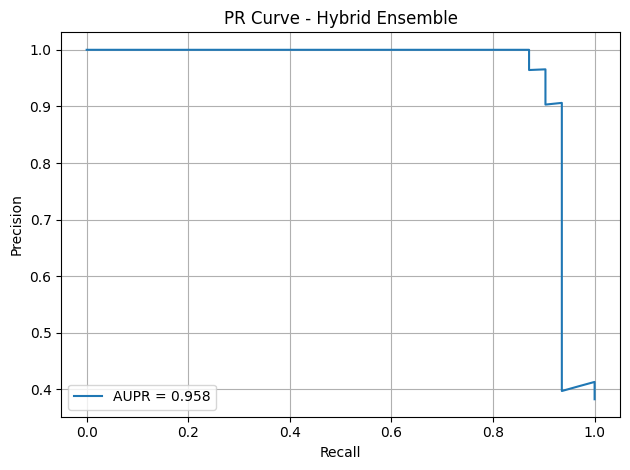

In [ ]:
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress harmless warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    accuracy_score, f1_score, recall_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

# === Load and clean data ===
df = pd.read_csv("cleaned_tcga_stad_data_with_encoded_clinical.csv")
X = df.drop(columns=["sample", "OS", "OS.time"])
y = df["OS"]
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# === Split into train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Define base models ===

# 1. MLP with scaling
mlp = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
)

# 2. QDA with regularization to prevent collinearity warnings
qda = make_pipeline(
    StandardScaler(),
    QuadraticDiscriminantAnalysis(reg_param=0.3)
)

# 3. LightGBM with stable parameters
lgbm = LGBMClassifier(
    random_state=42,
    min_gain_to_split=0.0,
    min_data_in_leaf=1,
    force_col_wise=True,
    verbose=-1
)

# === Train base models ===
mlp.fit(X_train, y_train)
qda.fit(X_train, y_train)
lgbm.fit(X_train, y_train)

# === Get prediction probabilities on train and test ===
train_preds = np.column_stack([
    mlp.predict_proba(X_train)[:, 1],
    qda.predict_proba(X_train)[:, 1],
    lgbm.predict_proba(X_train)[:, 1]
])
test_preds = np.column_stack([
    mlp.predict_proba(X_test)[:, 1],
    qda.predict_proba(X_test)[:, 1],
    lgbm.predict_proba(X_test)[:, 1]
])

# === Concatenate raw features with predictions ===
X_train_aug = np.hstack([X_train, train_preds])
X_test_aug = np.hstack([X_test, test_preds])

# === Meta-classifier: Logistic Regression (with more iterations and robust solver) ===
meta_model = LogisticRegression(max_iter=3000, solver='saga')
meta_model.fit(X_train_aug, y_train)

# === Final predictions ===
y_proba = meta_model.predict_proba(X_test_aug)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

# === Evaluation ===
print("Hybrid Meta-Ensemble (LGBM + MLP + QDA):")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("AUPR:", round(average_precision_score(y_test, y_proba), 4))

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Hybrid Ensemble")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Precision-Recall Curve ===
precision, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall_vals, precision, label=f"AUPR = {average_precision_score(y_test, y_proba):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve - Hybrid Ensemble")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


VotingClassifier (Soft) - Calibrated + Logistic + LGBM:
Accuracy: 0.9877
F1 Score: 0.9841
Recall: 1.0
ROC AUC: 0.9923
AUPR: 0.9851


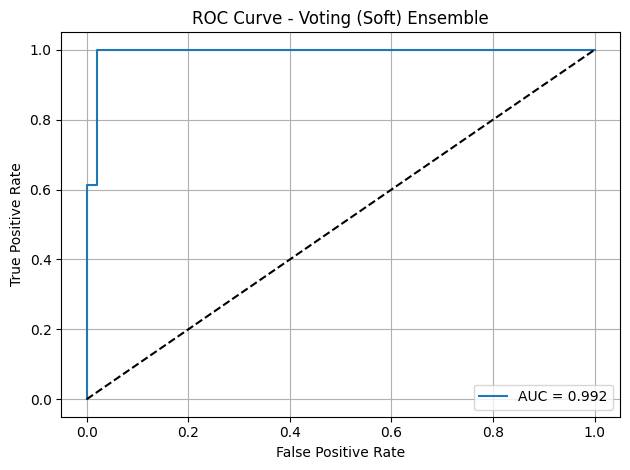

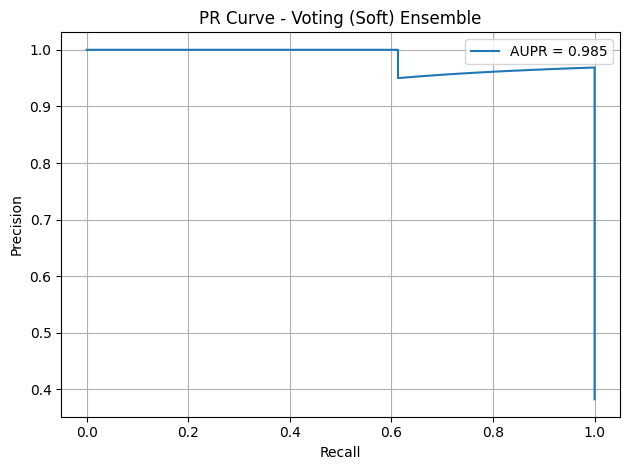

In [ ]:
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

# === Load cleaned dataset ===
df = pd.read_csv("cleaned_tcga_stad_data_with_encoded_clinical.csv")

# === Define features and target ===
X = df.drop(columns=["sample", "OS", "OS.time"])
y = df["OS"]
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# === Split data ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Base models ===

# Logistic Regression (scaled)
clf_log = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=3000, solver='saga', random_state=42)
)

# CalibratedClassifierCV (with logistic base)
clf_cal = make_pipeline(
    StandardScaler(),
    CalibratedClassifierCV(LogisticRegression(max_iter=1000, solver='lbfgs'), method='sigmoid', cv=5)
)

# LightGBM
clf_lgbm = LGBMClassifier(
    random_state=42,
    force_col_wise=True,
    verbose=-1
)

# === Voting Classifier (Soft Voting) ===
voting_clf = VotingClassifier(
    estimators=[
        ('calibrated', clf_cal),
        ('logistic', clf_log),
        ('lgbm', clf_lgbm)
    ],
    voting='soft'
)

# === Train ensemble ===
voting_clf.fit(X_train, y_train)

# === Predictions ===
y_proba = voting_clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

# === Evaluation ===
print("VotingClassifier (Soft) - Calibrated + Logistic + LGBM:")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("AUPR:", round(average_precision_score(y_test, y_proba), 4))

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Voting (Soft) Ensemble")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Precision-Recall Curve ===
precision, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall_vals, precision, label=f"AUPR = {average_precision_score(y_test, y_proba):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve - Voting (Soft) Ensemble")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


StackingClassifier (MLP + AdaBoost + LogisticRegression → LogisticRegression):
Accuracy: 0.9383
F1 Score: 0.9153
Recall: 0.871
ROC AUC: 0.94
AUPR: 0.9566


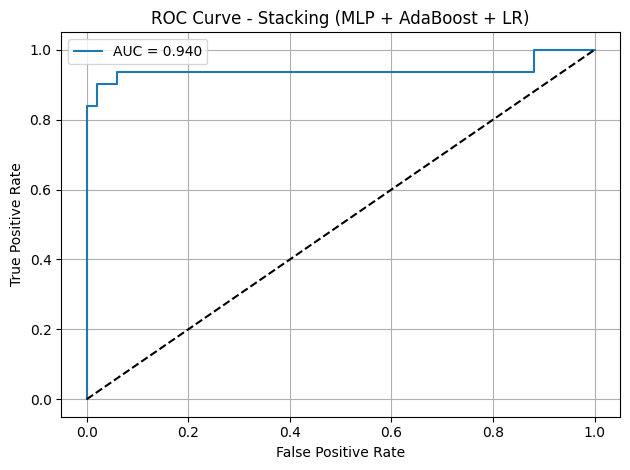

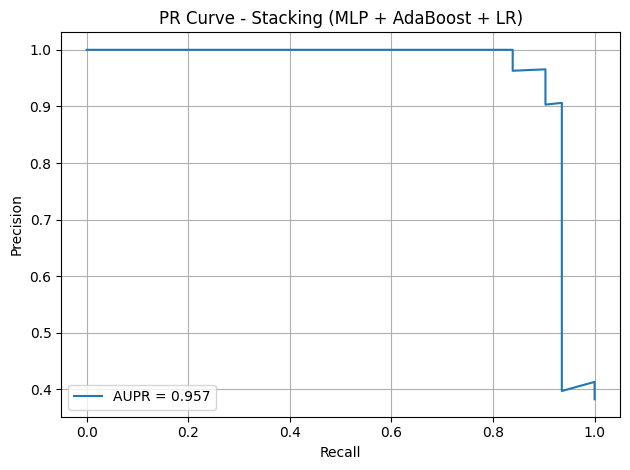

In [ ]:
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

# === Load dataset ===
df = pd.read_csv("cleaned_tcga_stad_data_with_encoded_clinical.csv")
X = df.drop(columns=["sample", "OS", "OS.time"])
y = df["OS"]
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# === Split dataset ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Define base learners ===

# MLP needs scaling
mlp = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
)

# AdaBoost
ada = AdaBoostClassifier(n_estimators=100, random_state=42)

# LogisticRegression with scaling
logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=3000, solver='saga', random_state=42)
)

# === Define meta-model ===
meta_model = LogisticRegression(max_iter=3000, solver='saga', random_state=42)

# === StackingClassifier ===
stack_clf = StackingClassifier(
    estimators=[
        ('mlp', mlp),
        ('ada', ada),
        ('logreg', logreg)
    ],
    final_estimator=meta_model,
    cv=5,
    passthrough=True
)

# === Train ensemble ===
stack_clf.fit(X_train, y_train)

# === Predict & evaluate ===
y_proba = stack_clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("StackingClassifier (MLP + AdaBoost + LogisticRegression → LogisticRegression):")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("AUPR:", round(average_precision_score(y_test, y_proba), 4))

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Stacking (MLP + AdaBoost + LR)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Precision-Recall Curve ===
precision, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall_vals, precision, label=f"AUPR = {average_precision_score(y_test, y_proba):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve - Stacking (MLP + AdaBoost + LR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


BalancedRandomForestClassifier Performance:
Accuracy: 0.9753
F1 Score: 0.9677
Recall: 0.9677
ROC AUC: 0.9987
AUPR: 0.998


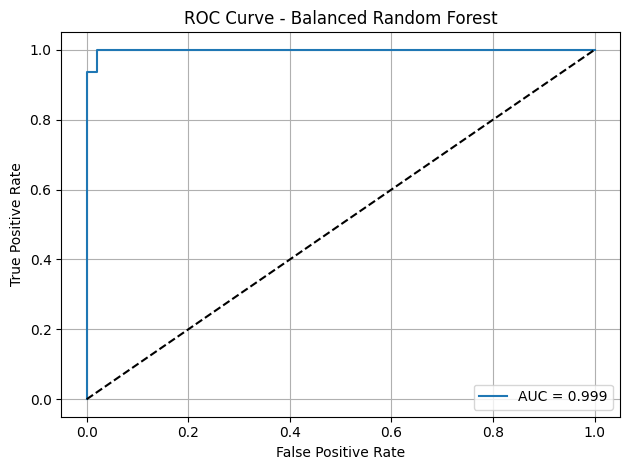

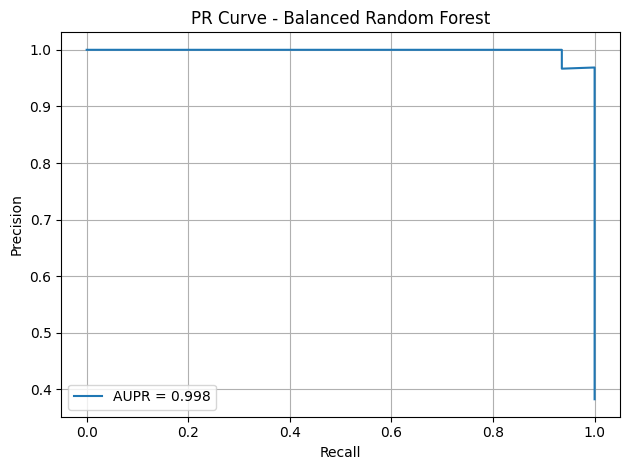

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

# === Load dataset ===
df = pd.read_csv("cleaned_tcga_stad_data_with_encoded_clinical.csv")

# === Define features and target ===
X = df.drop(columns=["sample", "OS", "OS.time"])
y = df["OS"]
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# === Train/Test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Balanced Random Forest ===
brf = BalancedRandomForestClassifier(
    n_estimators=100,
    random_state=42,
    sampling_strategy='auto',
    replacement=False,
    n_jobs=-1
)

brf.fit(X_train, y_train)
y_pred = brf.predict(X_test)
y_proba = brf.predict_proba(X_test)[:, 1]

# === Evaluation ===
print("BalancedRandomForestClassifier Performance:")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("AUPR:", round(average_precision_score(y_test, y_proba), 4))

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Balanced Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Precision-Recall Curve ===
precision, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall_vals, precision, label=f"AUPR = {average_precision_score(y_test, y_proba):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve - Balanced Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


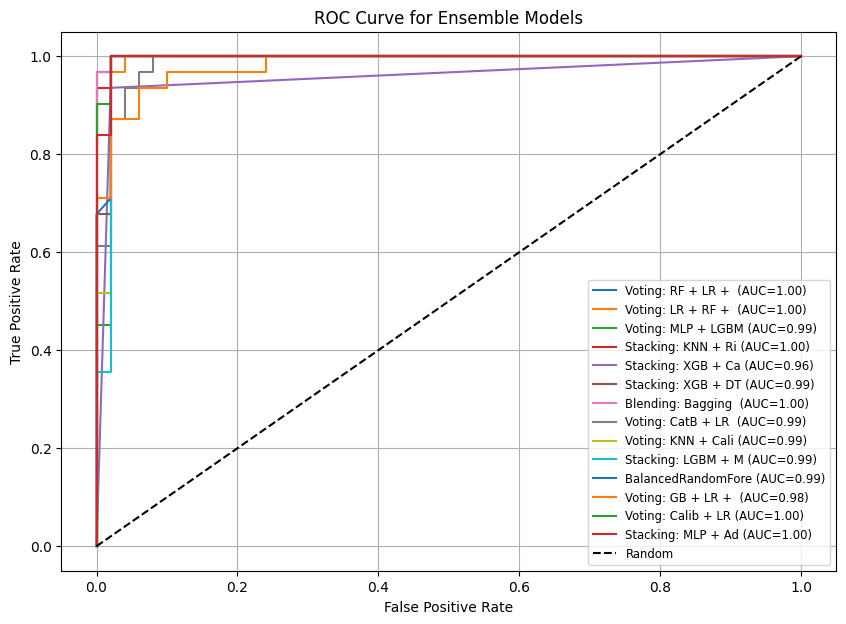

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import defaultdict

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve

# === Load Dataset ===
df = pd.read_csv("cleaned_tcga_stad_data_with_encoded_clinical.csv")
X = df.drop(columns=["sample", "OS", "OS.time"])
y = df["OS"]
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

results = defaultdict(dict)
roc_data = {}

def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        y_proba = y_pred

    results[name]["roc_auc"] = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_data[name] = (fpr, tpr)

# === Import Models ===
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import (
    VotingClassifier, StackingClassifier, AdaBoostClassifier, BaggingClassifier,
    GradientBoostingClassifier, RandomForestClassifier
)
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import lightgbm as lgb

# === Define Models (LGBM with verbose=-1) ===
models = {
    "Voting: RF + LR + CatB": VotingClassifier([
        ('rf', RandomForestClassifier(random_state=0)),
        ('lr', LogisticRegression(max_iter=1000)),
        ('cat', CatBoostClassifier(verbose=0, random_state=0))
    ], voting='soft'),

    "Voting: LR + RF + GNB": VotingClassifier([
        ('lr', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier()),
        ('gnb', GaussianNB())
    ], voting='soft'),

    "Voting: MLP + LGBM + Calib": VotingClassifier([
        ('mlp', make_pipeline(StandardScaler(), MLPClassifier(max_iter=1000))),
        ('lgbm', lgb.LGBMClassifier(verbose=-1)),  # ✅ Suppress warnings
        ('calib', make_pipeline(StandardScaler(), CalibratedClassifierCV()))
    ], voting='soft'),

    "Stacking: KNN + Ridge + BNB": StackingClassifier([
        ('knn', make_pipeline(StandardScaler(), KNeighborsClassifier())),
        ('ridge', make_pipeline(StandardScaler(), RidgeClassifier())),
        ('bnb', make_pipeline(Binarizer(), BernoulliNB()))
    ], final_estimator=LogisticRegression()),

    "Stacking: XGB + CatB + GBDT → DT": StackingClassifier([
        ('xgb', XGBClassifier(eval_metric='logloss', use_label_encoder=False, verbosity=0)),
        ('cat', CatBoostClassifier(verbose=0)),
        ('gbdt', GradientBoostingClassifier())
    ], final_estimator=DecisionTreeClassifier()),

    "Stacking: XGB + DT + BNB": StackingClassifier([
        ('xgb', XGBClassifier(eval_metric='logloss', use_label_encoder=False, verbosity=0)),
        ('dt', DecisionTreeClassifier()),
        ('bnb', BernoulliNB())
    ], final_estimator=LogisticRegression()),

    "Blending: Bagging + AdaB + Lasso": VotingClassifier([
        ('bag', BaggingClassifier()),
        ('ada', AdaBoostClassifier()),
        ('lasso', LogisticRegression(penalty='l1', solver='saga', max_iter=5000))
    ], voting='soft'),

    "Voting: CatB + LR + MLP": VotingClassifier([
        ('cat', CatBoostClassifier(verbose=0)),
        ('lr', LogisticRegression()),
        ('mlp', make_pipeline(StandardScaler(), MLPClassifier()))
    ], voting='soft'),

    "Voting: KNN + Calib + LGBM": VotingClassifier([
        ('knn', make_pipeline(StandardScaler(), KNeighborsClassifier())),
        ('calib', make_pipeline(StandardScaler(), CalibratedClassifierCV())),
        ('lgbm', lgb.LGBMClassifier(verbose=-1))  # ✅ Suppress warnings
    ], voting='soft'),

    "Stacking: LGBM + MLP + QDA": StackingClassifier([
        ('lgbm', lgb.LGBMClassifier(verbose=-1)),  # ✅ Suppress warnings
        ('mlp', make_pipeline(StandardScaler(), MLPClassifier())),
        ('qda', QuadraticDiscriminantAnalysis())
    ], final_estimator=LogisticRegression()),

    "BalancedRandomForest": BalancedRandomForestClassifier(),

    "Voting: GB + LR + BNB": VotingClassifier([
        ('gb', GradientBoostingClassifier()),
        ('lr', LogisticRegression()),
        ('bnb', BernoulliNB())
    ], voting='soft'),

    "Voting: Calib + LR + LGBM": VotingClassifier([
        ('calib', make_pipeline(StandardScaler(), CalibratedClassifierCV())),
        ('lr', LogisticRegression()),
        ('lgbm', lgb.LGBMClassifier(verbose=-1))  # ✅ Suppress warnings
    ], voting='soft'),

    "Stacking: MLP + AdaB + LR": StackingClassifier([
        ('mlp', make_pipeline(StandardScaler(), MLPClassifier())),
        ('ada', AdaBoostClassifier()),
        ('lr', make_pipeline(StandardScaler(), LogisticRegression()))
    ], final_estimator=LogisticRegression())
}

# === Run Evaluations ===
for name, model in models.items():
    evaluate_model(name, model)

# === Plot ROC Curve ===
plt.figure(figsize=(10, 7))
for name, (fpr, tpr) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name[:18]} (AUC={results[name]['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.title("ROC Curve for Ensemble Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize='small', loc='lower right')
plt.grid(True)
plt.savefig("ROC_Curve_plot.png", dpi=300, bbox_inches="tight")
plt.show()
